# CMSC 25025 / STAT 37601
## Final project: Diffusion Models
Writer: Yuwei Yan\
Email: yuweiyan@uchicago.edu\
Last update: May 2024\

This wrok is based on the paper <a href="https://arxiv.org/abs/2006.11239">Denoising Diffusion Probabilistic Models</a> by Jonathan Ho, Ajay Jain and Pieter Abbeel, NIPS (2020) with course materials in the class\

Some useful websites to refer to:\
https://lilianweng.github.io/posts/2021-07-11-diffusion-models/ \

Some Github links:\
https://github.com/lucidrains/denoising-diffusion-pytorch/tree/main\
https://github.com/dome272/Diffusion-Models-pytorch/tree/main \
https://github.com/TeaPearce/Conditional_Diffusion_MNIST/blob/main/script.py \


## Imports

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split,TensorDataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import trange, tqdm
import random
import multiprocessing
from functools import lru_cache
import os


# Check if you're on Google drive or on your own machine.
# Get path to your data.
if ('google' in str(get_ipython())):
    from google.colab import drive
    drive.mount('ME')
    # predir='/content/ME/My Drive/'
    predir = 'ME/My Drive/'
elif "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
    predir = '/kaggle/input/lsda-data/'
else:
    predir = os.path.join('/Users', 'yuweiyan', 'Google Drive')
    if os.path.isdir(os.path.join(predir, 'My Drive')):
        predir = os.path.join(predir, 'My Drive/')

datadir = predir+'LSDA_data/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# load data
@lru_cache(maxsize=128)
def load_data():
    data = np.float64(np.load(datadir+'mnist/MNIST_data.npy'))
    labels = np.float32(np.load(datadir+'mnist/MNIST_labels.npy'))
    return data, labels


def shuffle_(data, labels, seed=42):
    random.seed(seed)
    combined = list(zip(data, labels))
    random.shuffle(combined)
    # Unzip the shuffled list into separate data and labels lists
    shuffled_data, shuffled_labels = zip(*combined)
    # Convert the tuples back to numpy
    shuffled_data = np.array(shuffled_data)
    shuffled_labels = np.array(shuffled_labels)
    return data, labels


def split_data(data, labels, first_size):
    data, labels = shuffle_(data, labels)
    train_dat = data[0:first_size].reshape((-1, 1, 28, 28))
    train_labels = np.int32(labels[0:first_size])
    test_dat = data[first_size:].reshape((-1, 1, 28, 28))
    test_labels = np.int32(labels[first_size:])
    return (train_dat, train_labels), (test_dat, test_labels)


def get_mnist(train_size=55000, val_size=5000):
    data, labels = load_data()
    data = np.float32(data)/255
    (train_dat, train_labels), (test_dat, test_labels) = split_data(
        data, labels, first_size=train_size)
    (val_dat, val_labels), (test_dat, test_labels) = split_data(
        test_dat, test_labels, first_size=val_size)

    return (train_dat, train_labels), (val_dat, val_labels), (test_dat, test_labels)



## 1.(a) U-Net architecture

> The architecture of U-Net is unique in that it consists of a contracting path and an expansive path. The contracting path contains encoder layers that capture contextual information and reduce the spatial resolution of the input, while the expansive path contains decoder layers that decode the encoded data and use the information from the contracting path via skip connections to generate a segmentation map.



### Reverse diffusion process:
$$X_{t−1} = μ(X_t,t;θ) + σ_tZ_t$$  where $Z_t ∼ N(0,I_d)$ for t = T,...,1 ;  $X_t ∈ R^d$

The following code provides a U-Net architecture network $F (x, t; θ)$ that is used to compute $μ(x,t;θ)$.\
The network is composed of two main parts that can be viewed as encoder(contracting path) and decoder(expansive path): 


- #### Encoder(repeat 1-3 for 4 times):
    1. 2d Convolutional layer
    2. Add random features, which are randomly created using gaussian forier projection and passed to 2 fully connected layer before being added to the output of the Convolutional layer
    3. Normalize by group
   
- #### Decoder(repeat 4-6 for 4 time):
    4. 2d Transpose Convolutional layer: extend and restore image datas
    5. Add random features
    6. Normalize by group

In this network, t is only used in randomly generating the random features using gaussian forier projection. However, this randomness is not absolute.

#### Gaussian forier projection
The key idea behind Fourier embeddings is to encode the time t or noise level of the diffusion process into a high-dimensional vector representation that can be easily integrated into the neural network architecture of the diffusion model. This encoding is achieved by mapping the scalar time t or noise level value to a higher-dimensional vector using a Fourier feature mapping.

In [3]:
class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps."""

    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2)
                              * scale, requires_grad=False)

    def forward(self, x):
        x_proj = x * self.W * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
    """A fully connected layer that reshapes outputs to feature maps."""

    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        # expanding the dimensions of the tensor returned by self.dense(x)
        return self.dense(x)[..., None, None]


class ScoreNet_noise(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""

    def __init__(self, channels=[32, 64, 128, 256], embed_dim=256, group_num=4):

        super().__init__()

        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
                                   nn.Linear(embed_dim, embed_dim))

        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(group_num, num_channels=channels[0])
        self.conv2 = nn.Conv2d(
            channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(group_num, num_channels=channels[1])
        self.conv3 = nn.Conv2d(
            channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(group_num, num_channels=channels[2])
        self.conv4 = nn.Conv2d(
            channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(group_num, num_channels=channels[3])

        self.tconv4 = nn.ConvTranspose2d(
            channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(group_num, num_channels=channels[2])
        self.tconv3 = nn.ConvTranspose2d(
            channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(group_num, num_channels=channels[1])
        self.tconv2 = nn.ConvTranspose2d(
            channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(group_num, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(
            channels[0] + channels[0], 1, 3, stride=1)

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)

    def forward(self, x, t):
        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.embed(t))

        h1 = self.conv1(x)  # ...
        h1 += self.dense1(embed)  # ...
        h1 = self.gnorm1(h1)  # ...
        h1 = self.act(h1)  # ...
        h2 = self.conv2(h1)  # ...
        h2 += self.dense2(embed)
        h2 = self.gnorm2(h2)
        h2 = self.act(h2)
        h3 = self.conv3(h2)
        h3 += self.dense3(embed)
        h3 = self.gnorm3(h3)
        h3 = self.act(h3)
        h4 = self.conv4(h3)
        h4 += self.dense4(embed)
        h4 = self.gnorm4(h4)
        h4 = self.act(h4)

        h = self.tconv4(h4)  # ...
        h += self.dense5(embed)  # ...
        h = self.tgnorm4(h)
        h = self.act(h)
        h = self.tconv3(torch.cat([h, h3], dim=1))  # ...
        h += self.dense6(embed)
        h = self.tgnorm3(h)
        h = self.act(h)
        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.dense7(embed)
        h = self.tgnorm2(h)
        h = self.act(h)
        h = self.tconv1(torch.cat([h, h1], dim=1))

        return h

## 1.(b) Add scalar parameters ρ0 and ρ1

Based on experience we are going to model the actual conditional mean as 
$$μ(x, t; θ) = ρ_0(x − ρ_1F (x, t; θ))$$
$ρ_0$ and $ρ_1$ are scalar parameters that need to be estimated as well.

In [4]:
# Redefine ScoreNet
class ScoreNet_mu(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""

    def __init__(self, channels=[32, 64, 128, 256], embed_dim=256, group_num=4):

        super().__init__()

        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
                                   nn.Linear(embed_dim, embed_dim))

        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(group_num, num_channels=channels[0])
        self.conv2 = nn.Conv2d(
            channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(group_num, num_channels=channels[1])
        self.conv3 = nn.Conv2d(
            channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(group_num, num_channels=channels[2])
        self.conv4 = nn.Conv2d(
            channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(group_num, num_channels=channels[3])

        self.tconv4 = nn.ConvTranspose2d(
            channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(group_num, num_channels=channels[2])
        self.tconv3 = nn.ConvTranspose2d(
            channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(group_num, num_channels=channels[1])
        self.tconv2 = nn.ConvTranspose2d(
            channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(group_num, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(
            channels[0] + channels[0], 1, 3, stride=1)

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)

        # Initialize the scalar parameters ρ0 and ρ1
        self.rho_0 = nn.Parameter(torch.tensor(1.0))
        self.rho_1 = nn.Parameter(torch.tensor(1.0))

    def forward(self, x, t):
        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.embed(t))

        h1 = self.conv1(x)  # ...
        h1 += self.dense1(embed)  # ...
        h1 = self.gnorm1(h1)  # ...
        h1 = self.act(h1)  # ...
        h2 = self.conv2(h1)  # ...
        h2 += self.dense2(embed)
        h2 = self.gnorm2(h2)
        h2 = self.act(h2)
        h3 = self.conv3(h2)
        h3 += self.dense3(embed)
        h3 = self.gnorm3(h3)
        h3 = self.act(h3)
        h4 = self.conv4(h3)
        h4 += self.dense4(embed)
        h4 = self.gnorm4(h4)
        h4 = self.act(h4)

        h = self.tconv4(h4)  # ...
        h += self.dense5(embed)  # ...
        h = self.tgnorm4(h)
        h = self.act(h)
        h = self.tconv3(torch.cat([h, h3], dim=1))  # ...
        h += self.dense6(embed)
        h = self.tgnorm3(h)
        h = self.act(h)
        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.dense7(embed)
        h = self.tgnorm2(h)
        h = self.act(h)
        h = self.tconv1(torch.cat([h, h1], dim=1))

        mu = self.rho_0 * (x - self.rho_1 * h)

        return mu

## 1.(c)

### Forward Process and predict_next
Let $0 < β_t < 1,t = 1,...,T$ be an increasing sequence.
Define $σ_t^2 = β_t = 1 − α_t.$
$$q_{t|t−1}(x_t|x_{t−1}) = N (\sqrt{α_t}x_{t−1}, (1 − α_t)I_d)$$

In [6]:
class Diffusion(nn.Module):
    def __init__(self, model, n_steps, device, min_beta, max_beta):
        super().__init__()
        self.model = model
        self.n_steps = n_steps
        self.device = device

        # Compute linear beta schedule
        beta = torch.linspace(min_beta, max_beta, n_steps,
                              dtype=torch.float64).to(device)

        # Store beta, alpha, and alpha_bar
        self.beta = beta
        self.alpha = 1 - beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def forward_process(self, x0, t):
        # Sample x_t given x_0
        # get noised images
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t-1])[:, None, None, None]
        sqrt_one_minus_alpha_bar = torch.sqrt(
            1 - self.alpha_bar[t-1])[:, None, None, None]
        eps1 = torch.randn_like(x0)
        eps2 = torch.randn_like(x0)

        # sample x_{t-1} from x0
        xt_pre = sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * eps1

        # sample x_t from x_{t-1}
        xt = torch.sqrt(self.alpha[t])[:, None, None, None] * xt_pre+(1-self.alpha[t][:, None, None, None])*eps2

        return xt.float(), xt_pre.float()

    def predict_next(self, xt, t):
        mus = self.model(xt, t.unsqueeze(1))
        return mus

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.n_steps, size=(n,))

## 1.(d) Loss Function1

For each mini-batch $X_{1}, \ldots, X_{b}$ of size $b$, we will draw a random integer $\mathbf{t}_{\mathbf{j}}$ between $0, \ldots, T-1$ 

draw a sample from $q_{\mathbf{t}_{\mathbf{j}}-1 \mid 0}\left(X_{\mathbf{t}_{\mathbf{j}}-1} \mid X_{0}\right)$ and then a sample from $q_{\mathbf{t}_{\mathbf{j}} \mid \mathbf{t}_{\mathbf{j}}-1}\left(X_{\mathbf{t}_{\mathbf{j}}} \mid X_{\mathbf{t}_{\mathbf{j}}-1}\right)$. Thus the loss for each example $X_{j}$ is:

$$
L\left(X_{j}, \theta\right)=\frac{\left|X_{\mathbf{t}_{\mathbf{j}}-1}-\mu\left(X_{\mathbf{t}_{\mathbf{j}}}, \mathbf{t}_{\mathbf{j}} ; \theta\right)\right|^{2}}{2\left(1-\alpha_{\mathbf{t}_{\mathbf{j}}}\right)}
$$

and is averaged over all the examples in the batch.

In [7]:
def loss_fun1(diffusion,alpha,data):
    
    t = diffusion.sample_timesteps(data.shape[0]).to(device)          
    xt, xt_pre = diffusion.forward_process(data, t)
    xt_pre_predict = diffusion.predict_next(xt, t)

    loss = torch.mean((xt_pre-xt_pre_predict)**2/(2*(1-alpha[t][:,None,None])))
    return loss

## 1.(e) Loss Function2

Here we repeat the calculating the loss with same sampling t for multipul times to reduce the variance

In [8]:
def loss_fun2(diffusion,alpha,data, num_samples):
    
    t = diffusion.sample_timesteps(data.shape[0]).to(device)  
    loss=0.0
    
    for i in range(num_samples):
        xt, xt_pre = diffusion.forward_process(data, t)
        xt_pre_predict = diffusion.predict_next(xt, t)
        loss += torch.mean((xt_pre-xt_pre_predict)**2/(2*(1-alpha[t][:,None,None])))
        
    return loss/num_samples

## 1.(f) Train model

In [9]:
def testt(epoch,pars, diffusion, val_loader, ttype='val'):
    diffusion.model.eval()
    with torch.no_grad():
        device = pars.device
        epoch_loss = 0.0
        val_bar = tqdm(val_loader, desc=f"Epoch [{epoch + 1}/{pars.num_epochs}]", unit="batch")
        for data, _ in val_bar:
            data = data.to(device)
            loss =loss_fun1(diffusion,diffusion.alpha,data)
            epoch_loss += loss.item()

        epoch_loss /= len(val_loader)
    return epoch_loss


def train(pars):
    device = pars.device
    if pars.dataset == 'mnist':
        train, val, test = get_mnist(pars.train_size, pars.val_size)
        
        # Create TensorDataset for train and validation data
        train_dataset = TensorDataset(torch.from_numpy(train[0]), torch.from_numpy(train[1]))
        val_dataset = TensorDataset(torch.from_numpy(val[0]), torch.from_numpy(val[1]))
        
        # Create DataLoader for train and validation datasets
        train_loader = DataLoader(train_dataset, batch_size=pars.batch_size, shuffle=True, num_workers=4, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=pars.batch_size, shuffle=False, num_workers=4, pin_memory=True)

    if not pars.model_path:
        model = pars.model_type().to(device)
    else:
        model = torch.load(model_path).to(device)
    
    # Set learning rate for all parameters except ρ0 and ρ1
    base_params = [param for name, param in model.named_parameters() if name not in ['module.rho0', 'module.rho1']]
    rho_params = [param for name, param in model.named_parameters() if name in ['module.rho0', 'module.rho1']]

    optimizer = pars.optimizer([
        {'params': base_params, 'lr': pars.lr_base_params},
        {'params': rho_params, 'lr': pars.lr_rho_params}
    ])

    diffusion = Diffusion(model=model, n_steps=pars.n_steps, device=device, min_beta=pars.min_beta,
                          max_beta=pars.max_beta)

    writer = SummaryWriter()

    epoch_loss_list, epoch_loss_val_list = [], []
    best_val_loss = float('inf')
    best_model = None

    for epoch in range(pars.num_epochs):
        epoch_loss = 0.0
        train_bar = tqdm(train_loader, desc=f"Epoch [{epoch + 1}/{pars.num_epochs}]", unit="batch")
        for data, _ in train_bar:
            data = data.to(device)
            loss =loss_fun1(diffusion,diffusion.alpha,data)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Reduce learning rate by a factor of 10 every 20 epochs
        if (epoch + 1) % 20 == 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.1

        epoch_loss /= len(train_loader)
        epoch_loss_val = testt(epoch, pars, diffusion,val_loader,'val')
        epoch_loss_list.append(epoch_loss)
        epoch_loss_val_list.append(epoch_loss_val)

        writer.add_scalar('train/loss', epoch_loss, epoch)
        writer.add_scalar('val/loss', epoch_loss_val, epoch)
        
        for i, param_group in enumerate(optimizer.param_groups):
            writer.add_scalar(f'learning_rate/group_{i}', param_group['lr'], epoch)
        
        print(f"Epoch [{epoch + 1}/{pars.num_epochs}], train Loss: {epoch_loss:.4f}", end=", ")
        print(f'val Loss: {epoch_loss_val:.4f}')

        # Keep track of the best model based on validation loss
        if epoch_loss_val < best_val_loss:
            best_val_loss = epoch_loss_val
            best_model = diffusion.model.state_dict()
        
        # Release unused GPU memory after each epoch
        torch.cuda.empty_cache()

    # Save the best model
    torch.save(best_model, '/kaggle/working/best_model_ScoreNet_mu.pth')
    # Load the best model parameters into the model
    diffusion.model.load_state_dict(best_model)
    return diffusion,epoch_loss_list,epoch_loss_val_list


In [11]:
class pars(object):
    def __init__(self):
        # hyperparameters: learning
        self.batch_size = 100
        self.learning_rate = .001
        self.num_epochs = 60

        self.optimizer = optim.AdamW
        self.lr_base_params = 0.01
        self.lr_rho_params = 0.2

        self.dataset = 'mnist'
        self.train_size = 50000
        self.val_size = 5000

        self.n_steps = 200
        self.min_beta = 0.0001
        self.max_beta = 0.1

        self.input_dim = 28*28
        self.device = device
        self.model_path= ''
        self.model_type=ScoreNet_mu


pars0=pars()
diffusion,err_rates_train, err_rates_val=train(pars0)

Epoch [1/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [1/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [1/60], train Loss: 6.4934, val Loss: 0.2161


Epoch [2/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [2/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [2/60], train Loss: 0.1940, val Loss: 0.1695


Epoch [3/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [3/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [3/60], train Loss: 0.1631, val Loss: 0.1562


Epoch [4/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [4/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [4/60], train Loss: 0.1504, val Loss: 0.1356


Epoch [5/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [5/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [5/60], train Loss: 0.1405, val Loss: 0.1358


Epoch [6/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [6/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [6/60], train Loss: 0.1266, val Loss: 0.1232


Epoch [7/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [7/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [7/60], train Loss: 0.1176, val Loss: 0.1233


Epoch [8/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [8/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [8/60], train Loss: 0.1086, val Loss: 0.1098


Epoch [9/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [9/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [9/60], train Loss: 0.1075, val Loss: 0.1020


Epoch [10/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [10/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [10/60], train Loss: 0.1049, val Loss: 0.1149


Epoch [11/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [11/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [11/60], train Loss: 0.1027, val Loss: 0.0993


Epoch [12/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [12/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [12/60], train Loss: 0.1027, val Loss: 0.1102


Epoch [13/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [13/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [13/60], train Loss: 0.1028, val Loss: 0.1022


Epoch [14/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [14/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [14/60], train Loss: 0.1043, val Loss: 0.1014


Epoch [15/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [15/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [15/60], train Loss: 0.1021, val Loss: 0.1089


Epoch [16/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [16/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [16/60], train Loss: 0.1016, val Loss: 0.0987


Epoch [17/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [17/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [17/60], train Loss: 0.1041, val Loss: 0.0996


Epoch [18/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [18/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [18/60], train Loss: 0.1023, val Loss: 0.0984


Epoch [19/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [19/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [19/60], train Loss: 0.0991, val Loss: 0.0968


Epoch [20/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [20/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [20/60], train Loss: 0.1012, val Loss: 0.1033


Epoch [21/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [21/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [21/60], train Loss: 0.0999, val Loss: 0.0995


Epoch [22/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [22/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [22/60], train Loss: 0.1018, val Loss: 0.0986


Epoch [23/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [23/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [23/60], train Loss: 0.0994, val Loss: 0.0980


Epoch [24/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [24/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [24/60], train Loss: 0.0968, val Loss: 0.0996


Epoch [25/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [25/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [25/60], train Loss: 0.0996, val Loss: 0.1075


Epoch [26/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [26/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [26/60], train Loss: 0.0991, val Loss: 0.1006


Epoch [27/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [27/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [27/60], train Loss: 0.1002, val Loss: 0.0981


Epoch [28/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [28/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [28/60], train Loss: 0.1000, val Loss: 0.1014


Epoch [29/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [29/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [29/60], train Loss: 0.0981, val Loss: 0.1003


Epoch [30/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [30/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [30/60], train Loss: 0.1001, val Loss: 0.1003


Epoch [31/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [31/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [31/60], train Loss: 0.1001, val Loss: 0.1009


Epoch [32/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [32/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [32/60], train Loss: 0.1019, val Loss: 0.0983


Epoch [33/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [33/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [33/60], train Loss: 0.1007, val Loss: 0.1025


Epoch [34/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [34/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [34/60], train Loss: 0.0978, val Loss: 0.0937


Epoch [35/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [35/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [35/60], train Loss: 0.1036, val Loss: 0.1031


Epoch [36/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [36/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [36/60], train Loss: 0.1013, val Loss: 0.0974


Epoch [37/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [37/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [37/60], train Loss: 0.1010, val Loss: 0.1031


Epoch [38/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [38/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [38/60], train Loss: 0.1016, val Loss: 0.0967


Epoch [39/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [39/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [39/60], train Loss: 0.1005, val Loss: 0.1052


Epoch [40/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [40/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [40/60], train Loss: 0.1010, val Loss: 0.0957


Epoch [41/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [41/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [41/60], train Loss: 0.0995, val Loss: 0.0958


Epoch [42/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [42/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [42/60], train Loss: 0.1018, val Loss: 0.0994


Epoch [43/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [43/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [43/60], train Loss: 0.1014, val Loss: 0.1024


Epoch [44/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [44/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [44/60], train Loss: 0.1006, val Loss: 0.0980


Epoch [45/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [45/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [45/60], train Loss: 0.1002, val Loss: 0.0986


Epoch [46/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [46/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [46/60], train Loss: 0.1010, val Loss: 0.0966


Epoch [47/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [47/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [47/60], train Loss: 0.1017, val Loss: 0.0953


Epoch [48/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [48/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [48/60], train Loss: 0.1027, val Loss: 0.0991


Epoch [49/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [49/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [49/60], train Loss: 0.1004, val Loss: 0.0989


Epoch [50/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [50/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [50/60], train Loss: 0.1012, val Loss: 0.1012


Epoch [51/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [51/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [51/60], train Loss: 0.0995, val Loss: 0.1006


Epoch [52/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [52/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [52/60], train Loss: 0.0994, val Loss: 0.0922


Epoch [53/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [53/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [53/60], train Loss: 0.0997, val Loss: 0.0994


Epoch [54/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [54/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [54/60], train Loss: 0.0996, val Loss: 0.1034


Epoch [55/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [55/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [55/60], train Loss: 0.1009, val Loss: 0.0985


Epoch [56/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [56/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [56/60], train Loss: 0.1019, val Loss: 0.0962


Epoch [57/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [57/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [57/60], train Loss: 0.1003, val Loss: 0.0967


Epoch [58/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [58/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [58/60], train Loss: 0.1015, val Loss: 0.1012


Epoch [59/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [59/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [59/60], train Loss: 0.0985, val Loss: 0.0985


Epoch [60/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [60/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [60/60], train Loss: 0.1003, val Loss: 0.0977


## 1. (g) Sample imgs

In [44]:
def sample(diffusion,n):
    diffusion.model.eval()
    with torch.no_grad():
        
        x = torch.randn((n, 1, 28, 28)).to(diffusion.device)
        
        for i in tqdm(reversed(range(0, diffusion.n_steps)), position=1,total=diffusion.n_steps):
            t = (torch.ones(n) * i).long().to(diffusion.device)
            mu = diffusion.predict_next(x.float(), t)
            alpha = diffusion.alpha[t][:, None, None, None]
            eps = torch.randn_like(x)
            x = mu+torch.sqrt(1-alpha)*eps

    return x

def resize_img(x):
    x = (x.clamp(-1, 1) + 1) / 2
    x = (x * 255).type(torch.uint8)
    return x


def plot_imgs(imgs):
    plt.figure(figsize=(16, 12))
    for j in range(len(imgs)):
        plt.subplot(1, len(imgs), j+1)
        plt.imshow(imgs[j],cmap='gray')
        plt.axis('off')
    plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]

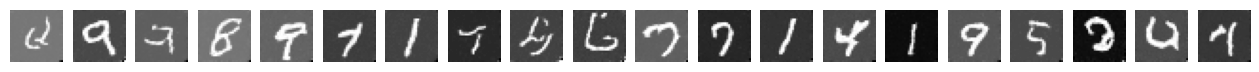

In [75]:
sample_imgs=sample(diffusion,1000)
resize_sample_imgs=resize_img(sample_imgs)
sample_imgs=sample_imgs.squeeze(1).cpu().numpy()
resize_sample_imgs=resize_sample_imgs.squeeze(1).cpu().numpy()

plot_imgs(resize_sample_imgs[:20])

## 1.(h) Calculate FID

In [19]:
def calculate_fid(Pg , Pd):
    """
    Calculate the Fréchet Inception Distance (FID) between two data distributions.
    
    Args:
        Pg (np.ndarray[2D]): Generated data distribution, where each row represents a data point.
        Pd (np.ndarray[2D]): Test data distribution, where each row represents a data point.

    """
    # Calculate the means of the data distributions
    mu1 = np.mean(Pg, axis=0)  # Shape: (n_features,)
    mu2 = np.mean(Pd, axis=0)  # Shape: (n_features,)
    
    # Calculate the covariance matrices of the data distributions
    sigma1 = np.cov(Pg, rowvar=False)  # Shape: (n_features, n_features)
    sigma2 = np.cov(Pd, rowvar=False)  # Shape: (n_features, n_features)
    
    # Calculate the squared Euclidean distance between the means
    diff = mu1 - mu2
    mean_term = np.dot(diff, diff)
    
    # Calculate the square root of the product of the covariance matrices
    sqrt_sigma1 = sqrtm(sigma1)
    sqrt_sigma2 = sqrtm(sigma2)
    
    cov_term = np.trace(sigma1 + sigma2 - 2 * sqrtm(sqrt_sigma1.dot(sigma2).dot(sqrt_sigma1)))
    
    # Calculate the FID
    fid = mean_term + cov_term
    
    return fid

def sqrtm(A):
    """
    explicit computation of the square root of a positive definite symmetric matrix using spectral decomposition.
    """
    # Perform spectral decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(A)
    
    # Ensure non-negative eigenvalues
    eigenvalues = np.maximum(eigenvalues, 0)
    
    # Calculate the square root of the eigenvalues
    sqrt_eigenvalues = np.sqrt(eigenvalues)
    
    # Reconstruct the square root of the matrix
    sqrt_A = eigenvectors.dot(np.diag(sqrt_eigenvalues)).dot(eigenvectors.T)
    
    return sqrt_A

In [77]:
train, val, test = get_mnist(pars0.train_size, pars0.val_size)
calculate_fid(sample_imgs.reshape(-1,784),train[0].reshape(-1,784))

8.596437976852252

## 2.(a)(b)

In [67]:
class Diffusion(nn.Module):
    def __init__(self, model, n_steps, device, min_beta, max_beta):
        super().__init__()
        self.model = model
        self.n_steps = n_steps
        self.device = device

        # Compute linear beta schedule
        beta = torch.linspace(min_beta, max_beta, n_steps,
                              dtype=torch.float64).to(device)

        # Store beta, alpha, and alpha_bar
        self.beta = beta
        self.alpha = 1 - beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def forward_process(self, x0, t):
        # Sample x_t given x_0
        # get noised images
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])[:, None, None, None]
        sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar[t])[:, None, None, None]
        eps = torch.randn_like(x0)
        # sample x_{t} from x0
        xt = sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * eps
        return xt.float(), eps.float()

    def predict_next(self, xt, t):
        mus=self.model(xt,t.unsqueeze(1))
        return mus

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.n_steps, size=(n,))

In [68]:
def testt(epoch,pars, diffusion, val_loader, ttype='val'):
    diffusion.model.eval()
    with torch.no_grad():
        device = pars.device
        epoch_loss = 0.0
        val_bar = tqdm(val_loader, desc=f"Epoch [{epoch + 1}/{pars.num_epochs}]", unit="batch")
        for data, _ in val_bar:
            data = data.to(device)
            t = diffusion.sample_timesteps(data.shape[0]).to(device)
            xt, noise = diffusion.forward_process(data, t)
            predicted_noise = diffusion.predict_next(xt, t)
            loss = nn.MSELoss()(predicted_noise,noise)
            epoch_loss += loss.item()

        epoch_loss /= len(val_loader)
    return epoch_loss


def train(pars):
    device = pars.device
    if pars.dataset == 'mnist':
        train, val, test = get_mnist(pars.train_size, pars.val_size)
        
        # Create TensorDataset for train and validation data
        train_dataset = TensorDataset(torch.from_numpy(train[0]), torch.from_numpy(train[1]))
        val_dataset = TensorDataset(torch.from_numpy(val[0]), torch.from_numpy(val[1]))
        
        # Create DataLoader for train and validation datasets
        train_loader = DataLoader(train_dataset, batch_size=pars.batch_size, shuffle=True, num_workers=4, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=pars.batch_size, shuffle=False, num_workers=4, pin_memory=True)

    if not pars.model_path:
        model = pars.model_type().to(device)
    else:
        model = torch.load(model_path).to(device)
    
    optimizer = pars.optimizer(model.parameters(), lr=pars.lr)

    diffusion = Diffusion(model=model, n_steps=pars.n_steps, device=device, min_beta=pars.min_beta,
                          max_beta=pars.max_beta)

    writer = SummaryWriter()
    epoch_loss_list, epoch_loss_val_list = [], []
    best_val_loss = float('inf')
    best_model = None

    for epoch in range(pars.num_epochs):
        epoch_loss = 0.0
        train_bar = tqdm(train_loader, desc=f"Epoch [{epoch + 1}/{pars.num_epochs}]", unit="batch")
        for data, _ in train_bar:
            data = data.to(device)
            t = diffusion.sample_timesteps(data.shape[0]).to(device)
            xt, noise = diffusion.forward_process(data, t)
            predicted_noise = diffusion.predict_next(xt, t)
            loss = nn.MSELoss()(predicted_noise,noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Reduce learning rate by a factor of 10 every 20 epochs
        if (epoch + 1) % 20 == 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.1

        epoch_loss /= len(train_loader)
        epoch_loss_val = testt(epoch,pars, diffusion,val_loader,'val')
        epoch_loss_list.append(epoch_loss)
        epoch_loss_val_list.append(epoch_loss_val)

        writer.add_scalar('train/loss', epoch_loss, epoch)
        writer.add_scalar('val/loss', epoch_loss_val, epoch)
        
        for i, param_group in enumerate(optimizer.param_groups):
            writer.add_scalar(f'learning_rate/group_{i}', param_group['lr'], epoch)
        
        print(f"Epoch [{epoch + 1}/{pars.num_epochs}], train Loss: {epoch_loss:.4f}", end=", ")
        print(f'val Loss: {epoch_loss_val:.4f}')

        # Keep track of the best model based on validation loss
        if epoch_loss_val < best_val_loss:
            best_val_loss = epoch_loss_val
            best_model = diffusion.model.state_dict()

    # Save the best model
    torch.save(best_model, '/kaggle/working/best_model_ScoreNet_noise.pth')
    # Load the best model parameters into the model
    diffusion.model.load_state_dict(best_model)
    return diffusion,epoch_loss_list,epoch_loss_val_list


In [46]:
class pars(object):
    def __init__(self):
        # hyperparameters: learning
        self.batch_size = 100
        self.learning_rate = .001
        self.num_epochs = 60

        self.optimizer = optim.AdamW
        self.lr=0.01

        self.dataset = 'mnist'
        self.train_size = 50000
        self.val_size = 5000

        self.n_steps = 200
        self.min_beta = 0.0001
        self.max_beta = 0.1

        self.input_dim = 28*28
        self.device = device
        self.model_path= ''
        self.model_type=ScoreNet_noise


pars1=pars()
diffusion3,epoch_loss_list3,epoch_loss_val_list3=train(pars1)

Epoch [1/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [1/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [1/60], train Loss: 0.2981, val Loss: 0.1135


Epoch [2/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [2/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [2/60], train Loss: 0.0784, val Loss: 0.0570


Epoch [3/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [3/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [3/60], train Loss: 0.0491, val Loss: 0.0413


Epoch [4/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [4/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [4/60], train Loss: 0.0412, val Loss: 0.0383


Epoch [5/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [5/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [5/60], train Loss: 0.0377, val Loss: 0.0399


Epoch [6/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [6/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [6/60], train Loss: 0.0362, val Loss: 0.0328


Epoch [7/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [7/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [7/60], train Loss: 0.0345, val Loss: 0.0359


Epoch [8/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [8/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [8/60], train Loss: 0.0323, val Loss: 0.0304


Epoch [9/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [9/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [9/60], train Loss: 0.0316, val Loss: 0.0313


Epoch [10/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [10/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [10/60], train Loss: 0.0305, val Loss: 0.0292


Epoch [11/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [11/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [11/60], train Loss: 0.0294, val Loss: 0.0287


Epoch [12/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [12/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [12/60], train Loss: 0.0290, val Loss: 0.0354


Epoch [13/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [13/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [13/60], train Loss: 0.0295, val Loss: 0.0265


Epoch [14/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [14/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [14/60], train Loss: 0.0272, val Loss: 0.0268


Epoch [15/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [15/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [15/60], train Loss: 0.0294, val Loss: 0.0305


Epoch [16/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [16/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [16/60], train Loss: 0.0287, val Loss: 0.0264


Epoch [17/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [17/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [17/60], train Loss: 0.0260, val Loss: 0.0255


Epoch [18/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [18/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [18/60], train Loss: 0.0262, val Loss: 0.0263


Epoch [19/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [19/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [19/60], train Loss: 0.0316, val Loss: 0.0401


Epoch [20/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [20/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [20/60], train Loss: 0.0317, val Loss: 0.0269


Epoch [21/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [21/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [21/60], train Loss: 0.0247, val Loss: 0.0231


Epoch [22/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [22/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [22/60], train Loss: 0.0239, val Loss: 0.0233


Epoch [23/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [23/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [23/60], train Loss: 0.0233, val Loss: 0.0234


Epoch [24/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [24/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [24/60], train Loss: 0.0228, val Loss: 0.0223


Epoch [25/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [25/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [25/60], train Loss: 0.0224, val Loss: 0.0216


Epoch [26/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [26/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [26/60], train Loss: 0.0216, val Loss: 0.0214


Epoch [27/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [27/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [27/60], train Loss: 0.0215, val Loss: 0.0213


Epoch [28/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [28/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [28/60], train Loss: 0.0212, val Loss: 0.0205


Epoch [29/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [29/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [29/60], train Loss: 0.0211, val Loss: 0.0206


Epoch [30/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [30/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [30/60], train Loss: 0.0208, val Loss: 0.0205


Epoch [31/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [31/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [31/60], train Loss: 0.0207, val Loss: 0.0204


Epoch [32/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [32/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [32/60], train Loss: 0.0208, val Loss: 0.0204


Epoch [33/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [33/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [33/60], train Loss: 0.0206, val Loss: 0.0206


Epoch [34/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [34/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [34/60], train Loss: 0.0202, val Loss: 0.0202


Epoch [35/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [35/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [35/60], train Loss: 0.0205, val Loss: 0.0194


Epoch [36/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [36/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [36/60], train Loss: 0.0202, val Loss: 0.0204


Epoch [37/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [37/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [37/60], train Loss: 0.0204, val Loss: 0.0201


Epoch [38/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [38/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [38/60], train Loss: 0.0202, val Loss: 0.0197


Epoch [39/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [39/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [39/60], train Loss: 0.0200, val Loss: 0.0194


Epoch [40/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [40/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [40/60], train Loss: 0.0200, val Loss: 0.0194


Epoch [41/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [41/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [41/60], train Loss: 0.0195, val Loss: 0.0186


Epoch [42/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [42/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [42/60], train Loss: 0.0192, val Loss: 0.0198


Epoch [43/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [43/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [43/60], train Loss: 0.0194, val Loss: 0.0187


Epoch [44/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [44/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [44/60], train Loss: 0.0193, val Loss: 0.0192


Epoch [45/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [45/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [45/60], train Loss: 0.0189, val Loss: 0.0191


Epoch [46/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [46/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [46/60], train Loss: 0.0191, val Loss: 0.0190


Epoch [47/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [47/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [47/60], train Loss: 0.0193, val Loss: 0.0193


Epoch [48/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [48/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [48/60], train Loss: 0.0191, val Loss: 0.0187


Epoch [49/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [49/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [49/60], train Loss: 0.0192, val Loss: 0.0188


Epoch [50/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [50/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [50/60], train Loss: 0.0190, val Loss: 0.0188


Epoch [51/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [51/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [51/60], train Loss: 0.0192, val Loss: 0.0195


Epoch [52/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [52/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [52/60], train Loss: 0.0191, val Loss: 0.0184


Epoch [53/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [53/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [53/60], train Loss: 0.0191, val Loss: 0.0194


Epoch [54/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [54/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [54/60], train Loss: 0.0190, val Loss: 0.0188


Epoch [55/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [55/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [55/60], train Loss: 0.0190, val Loss: 0.0189


Epoch [56/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [56/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [56/60], train Loss: 0.0190, val Loss: 0.0184


Epoch [57/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [57/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [57/60], train Loss: 0.0190, val Loss: 0.0192


Epoch [58/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [58/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [58/60], train Loss: 0.0189, val Loss: 0.0189


Epoch [59/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [59/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [59/60], train Loss: 0.0189, val Loss: 0.0184


Epoch [60/60]:   0%|          | 0/500 [00:00<?, ?batch/s]

Epoch [60/60]:   0%|          | 0/50 [00:00<?, ?batch/s]

Epoch [60/60], train Loss: 0.0190, val Loss: 0.0187


## 2.(c)

In [47]:
def sample(diffusion,n):
    diffusion.model.eval()
    with torch.no_grad():
        
        x = torch.randn((n, 1, 28, 28)).to(diffusion.device)
        
        for i in tqdm(reversed(range(1, diffusion.n_steps)), position=1,total=diffusion.n_steps):
            t = (torch.ones(n) * i).long().to(diffusion.device)
            predicted_noise = diffusion.predict_next(x.float(), t)
            alpha = diffusion.alpha[t][:, None, None, None]
            alpha_hat = diffusion.alpha_bar[t][:, None, None, None]
            beta = diffusion.beta[t][:, None, None, None]
            if i > 1:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
    
    return x

def resize_img(x):
    x = (x.clamp(-1, 1) + 1) / 2
    x = (x * 255).type(torch.uint8)
    return x

  0%|          | 0/200 [00:00<?, ?it/s]

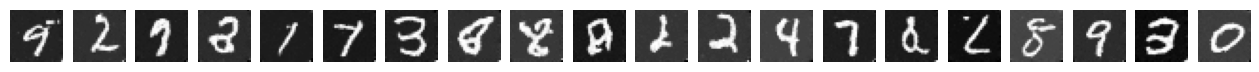

In [48]:
sample_imgs=sample(diffusion3,1000)

resize_sample_imgs=resize_img(sample_imgs)
sample_imgs=sample_imgs.squeeze(1).cpu().numpy()
resize_sample_imgs=resize_sample_imgs.squeeze(1).cpu().numpy()

plot_imgs(resize_sample_imgs[:20])

In [50]:
train, val, test = get_mnist(pars1.train_size, pars1.val_size)
calculate_fid(sample_imgs.reshape(-1,784),train[0].reshape(-1,784))

5.0802822892416195

## 3.

The second model which uses the Unet framework to predict the noises performs better than the first model which use Unet to predict 
the mean value of current state.\
We can tell the difference whether between the FID values (Model1:8.59, Model2:5.08) or the quality of images sampled. The sampled
images from model2 is more clear than those from the model1.\

The reasons may be that predicting noise is an easier learning task compared to directly predicting the denoised image since the noise has lower
variance compared to mu. Besides, Errors made by the model when predicting noise are less likely to accumulate over the denoising process